In [1]:
# Import libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

import itertools
import math
import pickle
import os
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D


from utils.config import *
from utils.ortool import *
from utils.Misc import *
from problems import *
from nets import *
from agents import *
from utils import *
from agents import AgentPPO, Actor_Critic


### Plot vehicle routes

In [2]:

def plot_customers(ax, customers, detailed = True):
    r"""
    :param ax:        Axes object to plot to
    :param customers: :math:`L_c \times D_c` tensor containing customers' features
    :param detailed:  Toggle printing features of each customer next to its node
        Default = False
    :type ax:         matplotlib.pyplot.Axes
    :type customers:  torch.Tensor(dtype = torch.float)
    :type detailed:   bool
    """

    ax.axis('equal')
    ax.set_axis_off()
    if detailed:
        ax.set_title("{} customers (Blue:Static, Red:Dynamic)".format(customers.size(0)-1))

    maxdem = customers[1:,3].max().item()
    mindem = customers[1:,3].min().item()
    s = [120+40*(dem-mindem)/(maxdem-mindem+0.2) for dem in customers[1:,3].tolist()]
    cmap = matplotlib.cm.coolwarm

    if customers.size(1) > 3: # Service time
        c = customers[1:,3].tolist()
        cnorm = matplotlib.colors.Normalize(-0.5, 0.5) # service time mean=10, std=2.5 (min)
    else:
        c = [1.0 for _ in customers[1:]]
        cnorm = matplotlib.colors.Normalize(-1, 1)
    
    ax.scatter(*zip(*customers[0:1,:2].tolist()), 200, 'g', 'd')
    ax.scatter(*zip(*customers[1:,:2].tolist()), s, c, 'o', cmap, cnorm)
            
    for j, cust in enumerate( customers.tolist() ):
        ax.text(cust[0],cust[1],str(j), fontsize = 10,
                horizontalalignment = 'center', verticalalignment = 'center')
    return ax

def discrete_cmap(N, base_cmap='ocean'):
    base = plt.cm.get_cmap(base_cmap) if isinstance(base_cmap, str) else base_cmap
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def plot_vehicle_routes(data_to_plot, routes_without_depot, markersize = 5):

    fig, ax1 = plt.subplots(1, 1, figsize = (12,10))
    
    depot = data_to_plot[0,:2].cpu().numpy()
    locs = data_to_plot[1:,:2].cpu().numpy()

    x_dep, y_dep = depot
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    legend = ax1.legend(loc='upper center')
    cmap = discrete_cmap(len(routes_without_depot) + 2)

    qvs = []
    total_dist = 0

    for veh_number, r in enumerate(routes_without_depot):
        r = np.array(r)
        color = cmap(len(routes_without_depot) - veh_number)
        coords = locs[r-1, :]
        xs, ys = coords.transpose()

        ax1 = plot_customers(ax1, data_to_plot)

        dist = 0
        x_prev, y_prev = x_dep, y_dep

        for (x, y) in coords:
                dist += np.sqrt((x - x_prev) ** 2 + (y - y_prev) ** 2)
                x_prev, y_prev = x, y

        dist += np.sqrt((x_dep - x_prev) ** 2 + (y_dep - y_prev) ** 2)
        total_dist += dist

        xs = np.append(xs,x_dep)
        xs = np.insert(xs,0,x_dep)
        ys = np.append(ys,y_dep)
        ys = np.insert(ys,0,y_dep)


        qv = ax1.quiver(
                        xs[:-1],
                        ys[:-1],
                        xs[1:] - xs[:-1],
                        ys[1:] - ys[:-1],
                        scale_units='xy',
                        angles='xy',
                        scale=1,
                        width = 0.004,
                        color=color,
                        label='Route{}, #Customers {},Distance {:.2f}'.format(
                        veh_number, 
                        len(r), 
                        dist))

        qvs.append(qv)

        ax1.set_title('Blue:Static, Red:Dyanamic,{} routes, total distance {:.2f}'.format(len(routes), total_dist))
        ax1.legend(handles=qvs)

In [4]:
args = ParseArguments()
Lambda = 0.2
dod = 0.75
horizon = 600
vehicle_count = 2

data = torch.load("./data/validation/{}_{}_{}_{}/val_accuracy.pth".format(Lambda, dod, vehicle_count, horizon ))

data_t = data
data_t.normalize()
print(data_t.vehicle_speed)
loader = DataLoader(data_t, batch_size=20, shuffle=False)

learner = Actor_Critic(4,4,161, encoder_layer=1, model_size = 128, ff_size_actor=256,ff_size_critic=256)
checkpoint = torch.load("./output/exp160_reward1_entropy0.05_0.2_0.75_2_230821/epoch15.pth", 
                        map_location = 'cpu')

learner.load_state_dict(checkpoint['model'])
learner.eval()
learner.greedy  = True

2.8452256774714453


## Plot Customers and Routes

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/w3/d_8f7c794lx5828018pzxrj40000gn/T/ipykernel_22256/1611954898.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap) if isinstance(base_cmap, str) else base_cmap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/w3/d_8f7c794lx5828018pzxrj40000gn/T/ipykernel_22256/1611954898.py:38: Matplot

[[126, 101, 14, 28, 71, 10, 1, 139, 34, 62, 134, 151, 86, 102, 30, 109, 152, 15, 88], [124, 111, 48, 75, 63, 135, 93, 27, 9, 37, 149, 147, 7, 153, 82, 103, 72, 20, 6, 142, 55], [140, 58, 113, 50, 98, 29, 8, 17, 115, 64, 53, 25, 138, 41, 23, 156, 47, 40, 36, 11, 60, 61]]
[[123, 56, 33, 115, 74, 69, 21, 105, 75, 122, 14, 93, 96, 112, 34, 59, 53, 143, 130], [133, 85, 47, 152, 116, 62, 125, 119, 67, 2, 106, 43, 83, 95, 44, 3, 72, 36, 89, 26, 28, 38], [45, 66, 84, 145, 127, 80, 103, 52, 158, 77, 17, 57, 9, 137, 1, 101, 39, 78, 128, 138]]
[[117, 108, 153, 78, 2, 1, 128, 34, 100, 42, 35, 94, 73, 41, 23, 145, 147, 143, 49, 90, 99], [69, 27, 62, 68, 30, 115, 98, 148, 92, 60, 101, 18, 123, 144, 103, 21, 7, 140, 142], [80, 114, 3, 55, 116, 15, 11, 113, 25, 24, 110, 95, 40, 141, 70, 156, 79]]
[[103, 96, 19, 52, 7, 92, 135, 83, 95, 131, 81, 25, 107, 123, 120, 58, 8, 59], [47, 159, 54, 124, 2, 37, 104, 61, 148, 29, 136, 153, 99, 126, 112, 27, 72, 149, 46], [63, 35, 138, 57, 86, 74, 130, 133, 1, 15, 

/var/folders/w3/d_8f7c794lx5828018pzxrj40000gn/T/ipykernel_22256/1611954898.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap) if isinstance(base_cmap, str) else base_cmap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/w3/d_8f7c794lx5828018pzxrj40000gn/T/ipykernel_22256/1611954898.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap) if isinstance(base_cmap, str) else base_cmap
No artists with labels found to put in legend.  Note that artists whose label sta

[[95, 108, 79, 21, 14, 32, 120, 80, 29, 151, 19, 156, 85, 66, 72, 75, 12, 39, 10, 5], [78, 145, 3, 82, 130, 84, 81, 160, 103, 25, 51, 109, 17, 57, 40, 100, 83, 113], [107, 30, 128, 53, 46, 64, 123, 74, 139, 89, 94, 158, 20, 138, 150, 52, 87, 34, 133, 112]]
[[134, 122, 78, 69, 15, 1, 21, 139, 135, 154, 3, 82, 33, 36, 70, 65], [153, 83, 137, 77, 102, 141, 159, 17, 126, 28, 156, 114, 68, 146, 149, 56, 75, 49, 115, 85, 127, 18], [120, 5, 158, 86, 105, 74, 72, 125, 129, 143, 111, 31, 95, 8, 90, 12, 109, 30, 93, 76, 10, 145, 79]]
[[13, 55, 16, 132, 98, 159, 4, 44, 48, 40, 112, 101, 152, 15, 93, 33, 120, 6, 125, 157, 17, 139, 19], [92, 18, 119, 118, 34, 105, 64, 114, 59, 46, 142, 66, 107, 23, 148, 154, 81, 10, 102, 42, 89, 158], [70, 135, 77, 7, 68, 127, 41, 79, 156, 86, 56, 14, 84, 11, 126, 151, 21, 141]]
[[129, 145, 116, 4, 35, 152, 127, 44, 109, 156, 112, 62, 113, 53, 39, 21, 108, 73, 48, 149, 59, 33], [121, 124, 94, 5, 7, 136, 49, 55, 65, 68, 8, 38, 47, 120, 10, 147, 30, 15, 90, 2, 138, 7

/var/folders/w3/d_8f7c794lx5828018pzxrj40000gn/T/ipykernel_22256/1611954898.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap) if isinstance(base_cmap, str) else base_cmap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/w3/d_8f7c794lx5828018pzxrj40000gn/T/ipykernel_22256/1611954898.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap) if isinstance(base_cmap, str) else base_cmap
No artists with labels found to put in legend.  Note that artists whose label sta

[[48, 132, 116, 113, 135, 21, 36, 131, 112, 101, 49, 34, 150, 93, 33, 115, 25, 117, 136, 100, 102, 103], [156, 66, 92, 107, 8, 6, 159, 78, 14, 72, 68, 91, 59, 140, 53, 71, 141, 89, 35, 56], [109, 19, 18, 88, 43, 67, 122, 54, 111, 99, 95, 106, 84, 63, 39, 110, 45, 13, 15, 79]]
[[67, 6, 99, 90, 153, 55, 56, 64, 107, 100, 33, 116, 135, 76, 150], [23, 124, 147, 117, 61, 141, 145, 88, 101, 121, 118, 11, 57, 62, 24, 87, 4, 122, 66, 27], [108, 157, 140, 19, 72, 77, 91, 120, 139, 63, 73, 52, 20, 143, 36, 17, 42, 75]]


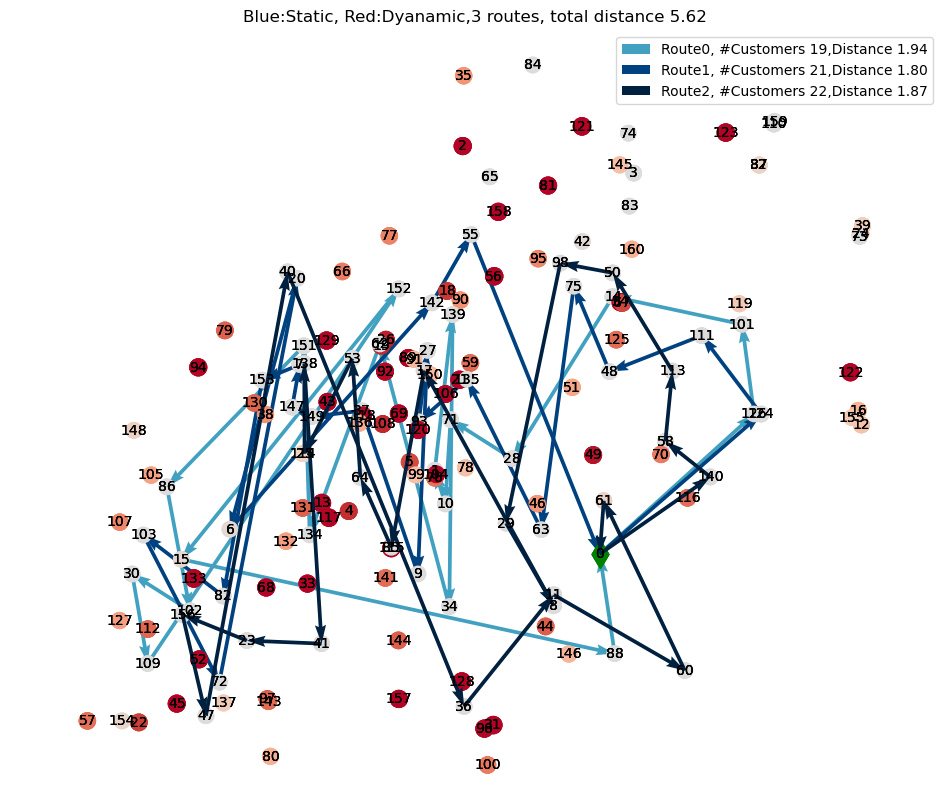

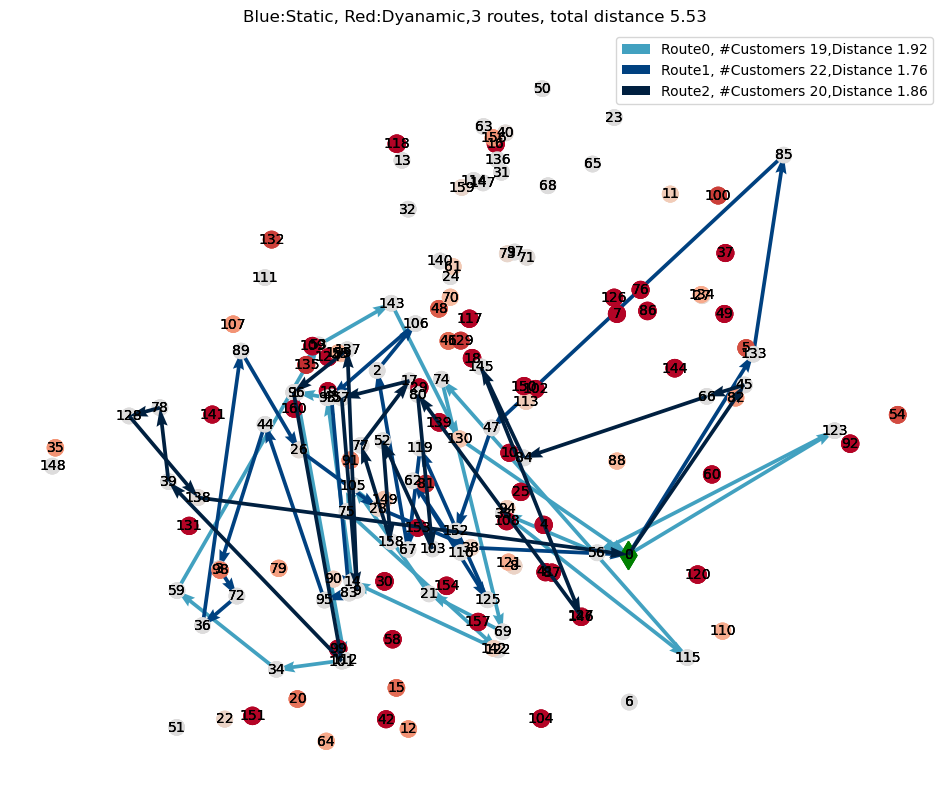

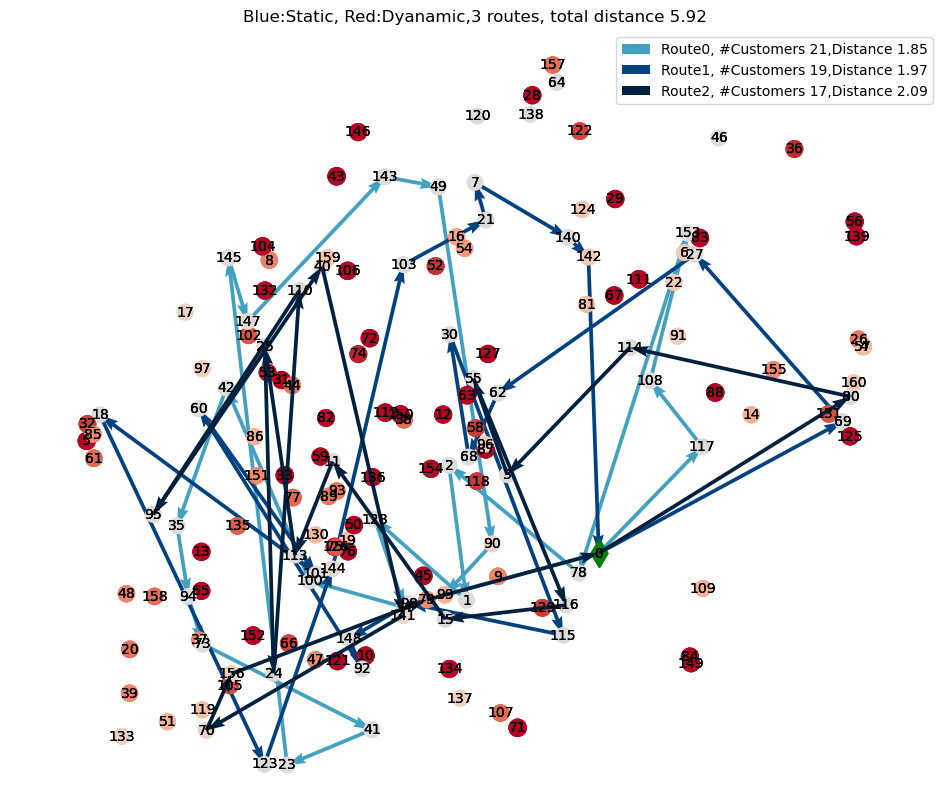

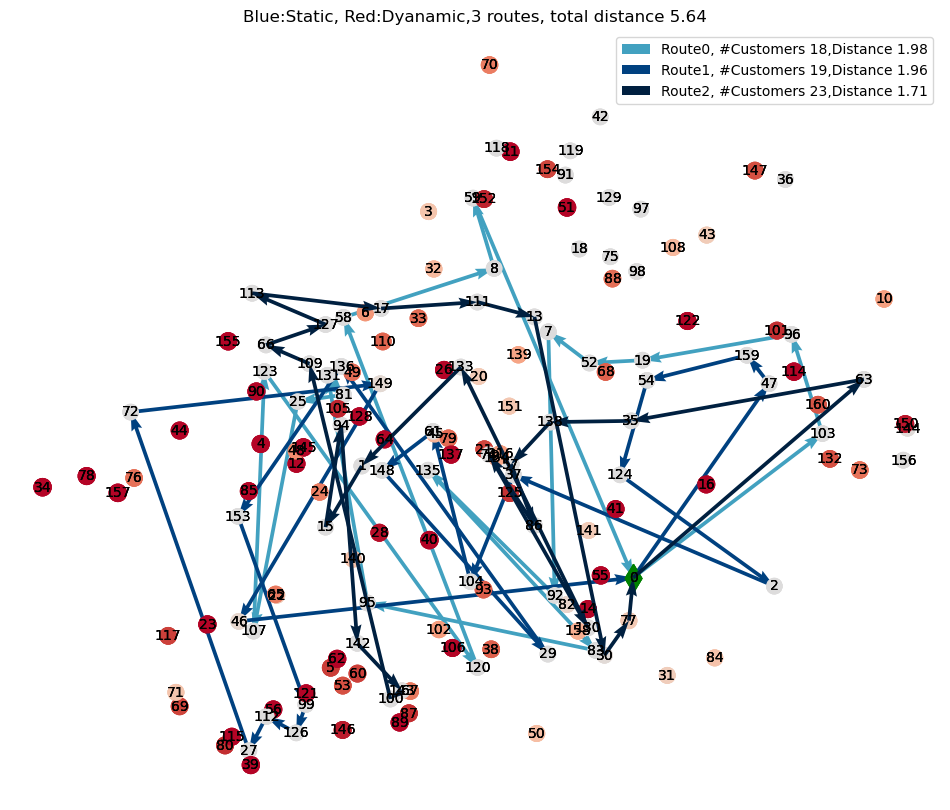

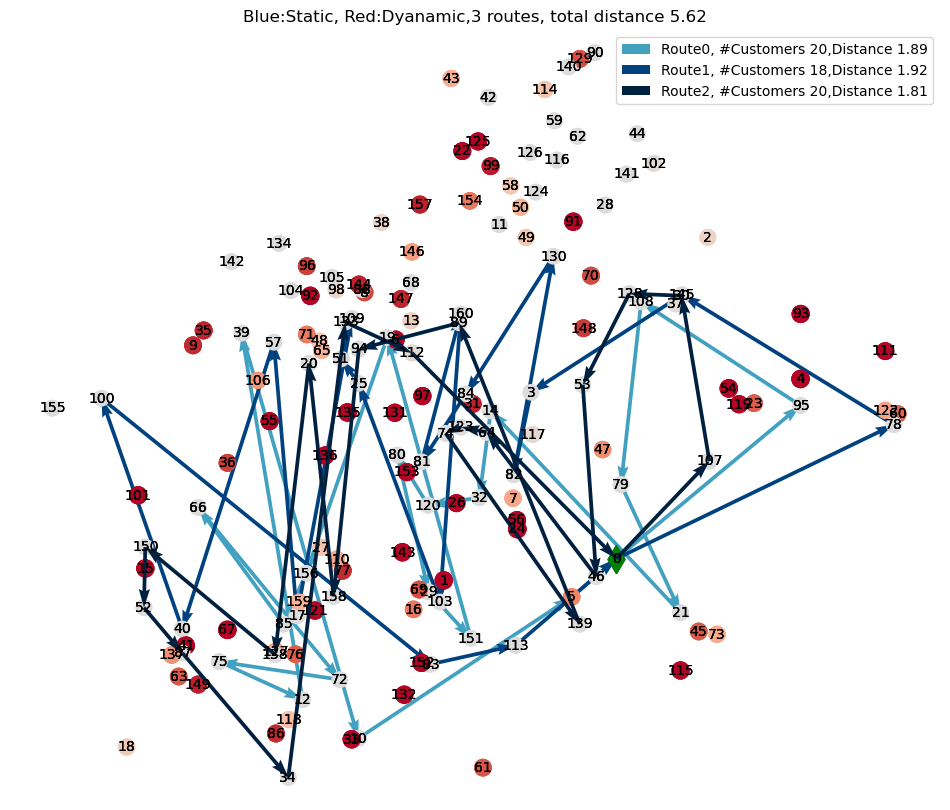

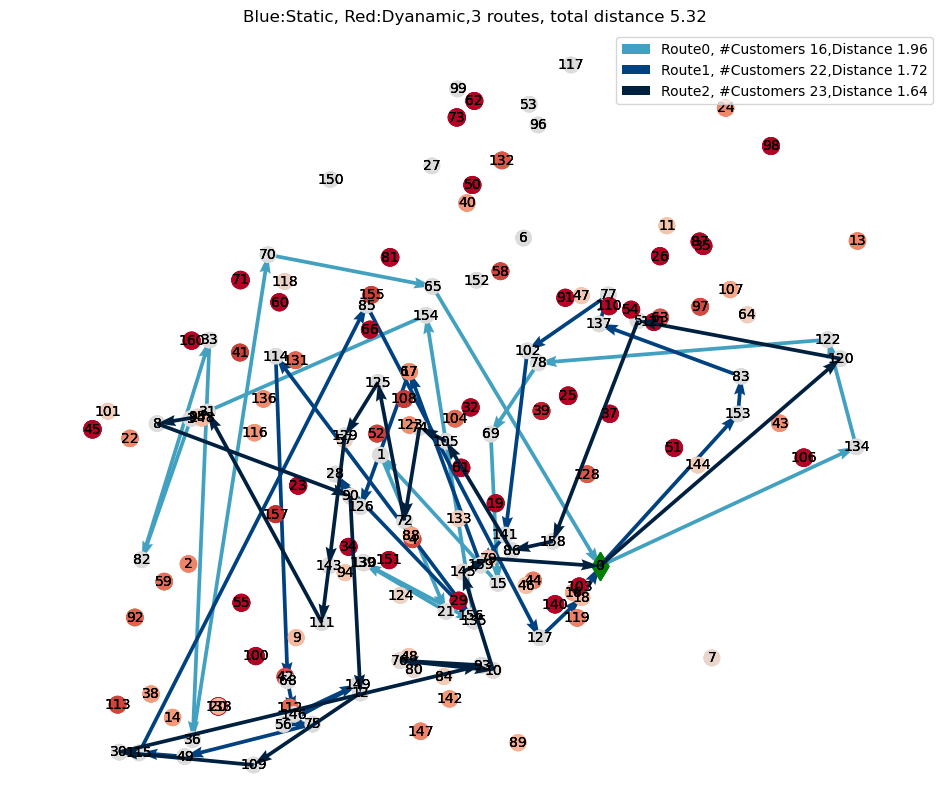

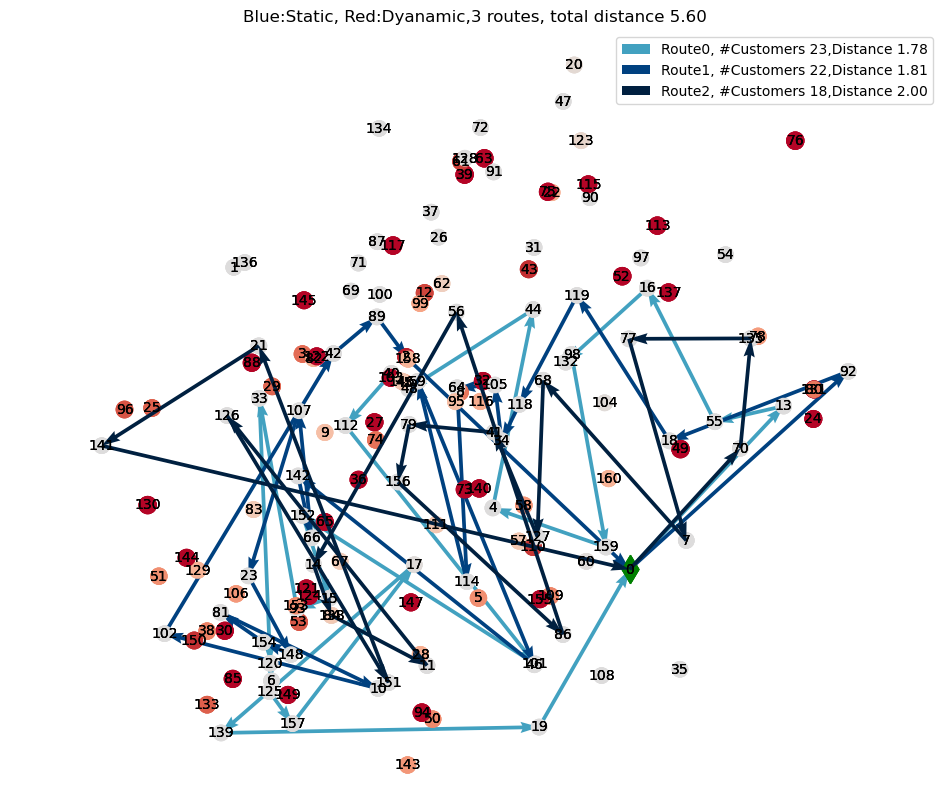

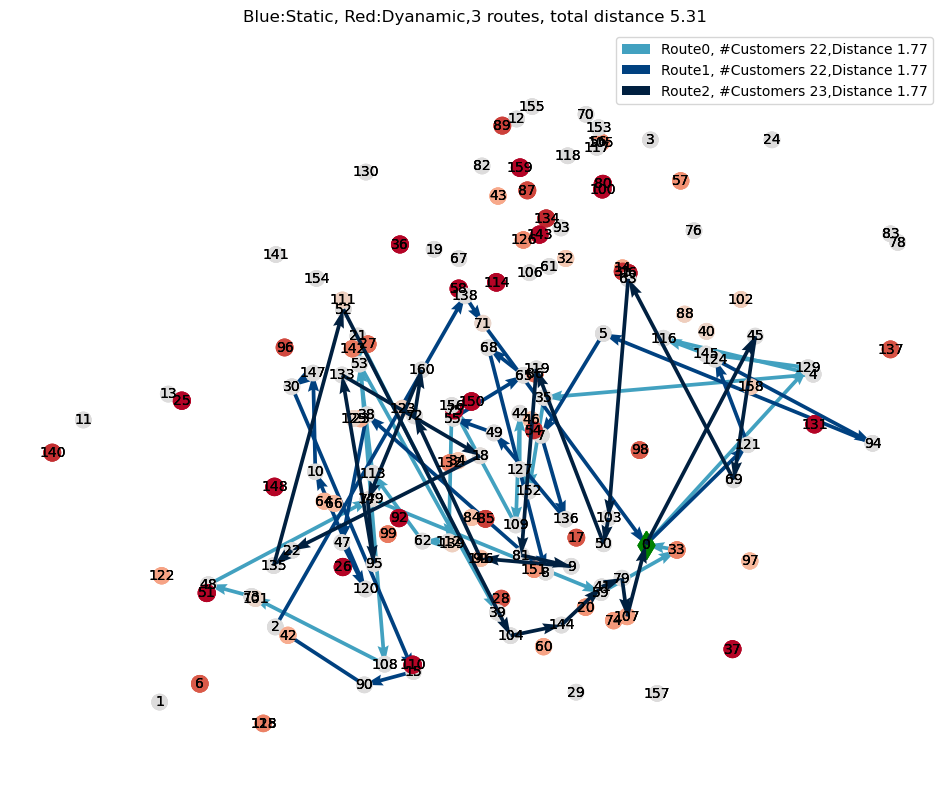

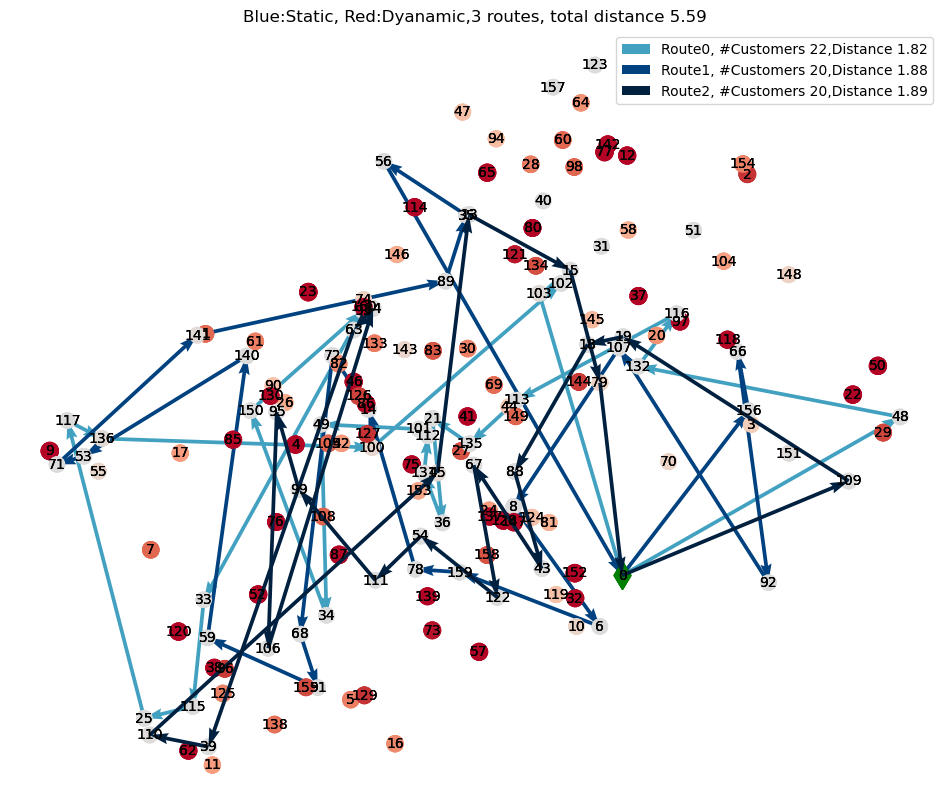

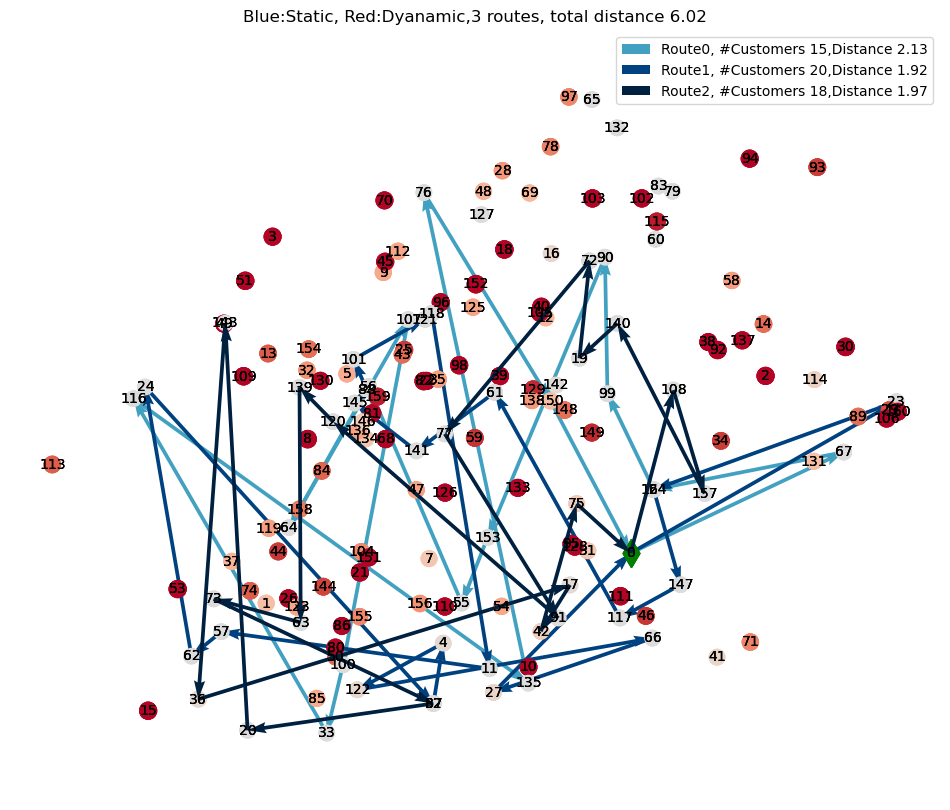

In [8]:
agent_actions = []
with torch.no_grad():
    for _, minibatch in enumerate(tqdm(loader)):
        env = DVRPSR_Environment(data = data_t,vehicle_count=3,pending_cost=0)
        actions,logps, rewards,_ = learner.act(env)
        #print(minibatch[0])
        #print(env.vehicles)
        #print(env.nodes)
        #print(actions)
        
        agent_actions.append(actions)
        
# Convert tensor to array
agent_actions_to_array = np.array([[[t[0][i].item(), t[1][i].item()] 
                                    for i in range(len(t[0]))] 
                                    for t in agent_actions[0]])
tours = []

for i in range(len(agent_actions_to_array[0])):
    temp = []
    for j in range(len(agent_actions_to_array)):
        temp.append(agent_actions_to_array[j][i])
    tours.append(temp)


for i, (data, tour) in enumerate(zip(env.nodes, tours)):
    
    tour = pd.DataFrame(tour)
    tour.columns = ['vehicles','customers']  
    
    # Create a grouping column
    tour['group'] = tour.groupby('vehicles').cumcount()

    # Reshape the DataFrame
    tour = tour.pivot(index='group', columns='vehicles', values='customers')

    # Rename the columns
    column_names = [f'vehicles_{val}' for val in tour.columns]
    tour.columns = column_names
    tour = tour.fillna(0).astype(int)

    routes = []
    for vehicle_name in list(tour.columns):
        routes.append(list(tour[vehicle_name]))

    routes_without_depot = []
    for route in routes:
        r = [cust for cust in route if cust!=0]
        routes_without_depot.append(r)
        
    print(routes_without_depot)
    if ((len(routes_without_depot[0]) >= 0 ) or (len(routes_without_depot[0]) >= 0)):
        plot_vehicle_routes(data, routes_without_depot)
    

## Quality of Service (QOS)

In [9]:
data = torch.load("./data/validation/{}_{}_{}_{}/val_accuracy.pth".format(Lambda, dod, vehicle_count, horizon ))

data_t = data
data_t.normalize()
print(data_t.vehicle_speed)
loader = DataLoader(data_t, batch_size=20, shuffle=False)

learner = Actor_Critic(4,4,161, encoder_layer=1, model_size = 128, ff_size_actor=256,ff_size_critic=256)
checkpoint = torch.load("./output/exp160_reward1_entropy0.05_0.2_0.75_2_230821/epoch15.pth", 
                        map_location = 'cpu')

learner.load_state_dict(checkpoint['model'])
learner.eval()
learner.greedy  = True

costs = []
QOS = []
static_AR = []
dyanamic_AR = []



with torch.no_grad():
    for _, minibatch in enumerate(tqdm(loader)):
        env = DVRPSR_Environment(data = data_t,vehicle_count=3,pending_cost=0)
        actions,_, rewards,_ = learner.act(env)
        costs.append(torch.stack(rewards).sum(dim=0).squeeze(-1))  
        
        # Calaculate Quality of Service:
        total_requests = (env.nodes[:,:,3]>=0).sum(1).float()
        total_requests_pending = (torch.logical_and(env.served^True, (env.nodes[:,:,3]>=0))).sum(1).float()
        QOS.append(1 - total_requests_pending/total_requests)  
        
        # Calculate static acceptance rate
        total_static_requests = (env.nodes[:,:,3]==0).sum(1).float()
        total_static_requests_pending = (torch.logical_and(env.served^True, (env.nodes[:,:,3]==0))).sum(1).float()
        static_AR.append(1 - total_static_requests_pending/total_static_requests)
        
        # Calculate dyanamic acceptance rate
        total_dyanamic_requests = (env.nodes[:,:,3] > 0).sum(1).float()
        total_dyanamic_requests_pending = (torch.logical_and(env.served^True, (env.nodes[:,:,3] > 0))).sum(1).float()
        dyanamic_AR.append(1 - total_dyanamic_requests_pending/total_dyanamic_requests)
        
        
    costs = torch.cat(costs, 0)
    QOS = torch.cat(QOS, 0)
    static_AR = torch.cat(static_AR, 0)
    dyanamic_AR = torch.cat(dyanamic_AR, 0)
    
QOS = [0 if math.isnan(x) else x for x in QOS]
static_AR = [0 if math.isnan(x) else x for x in static_AR]
dyanamic_AR = [0 if math.isnan(x) else x for x in dyanamic_AR]
    

print("Costs mean:{:.2f} +- std:{:.2f} and QOS {:.4f}, Static_AR {:.4f}, Dyanamic_AR {:.4f}".format(
       costs.mean(), costs.std(), np.mean(QOS), np.mean(static_AR), np.mean(dyanamic_AR)))     

2.8452256774714453


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]

Costs mean:6.23 +- std:0.31 and QOS 0.3752, Static_AR 0.8160, Dyanamic_AR 0.0576
